In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import logging # Allows us to check the progress of our LDA model
import re # Regex

# For Topic Modelling
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Visualising Topic Model
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import seaborn as sns

# Word cloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Enable in-notebook visualizations
%matplotlib inline
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore")

/Users/jacqualync/opt/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df=pd.read_excel('data/tweetfilter.xlsx', index_col = 0)
df

,tweets,time
77000,california adopts show power line pose danger,2016-06-01
77007,fire situation report wildfire california week,2016-06-01
77006,diego county wildfire force evacuate house fir...,2016-06-01
77005,california danielle nelisse paint landscape thank,2016-06-01
77004,diego county wildfire force evacuate,2016-06-01
...,...,...
77259,NaN,2016-09-30
77260,fast-moving california wildfire destroys home,2016-09-30
77261,fast-moving california destroys home news,2016-09-30
77251,california wildfire destroys home injures fire...,2016-09-30


In [3]:
def my_tokenizer(s):
    tokens = nltk.tokenize.word_tokenize(str(s))
    return tokens

df['title'] = df.tweets.apply(my_tokenizer)
df
#df.to_excel('data/redditcorpus.xlsx', index=True)

,tweets,time,title
77000,california adopts show power line pose danger,2016-06-01,"[california, adopts, show, power, line, pose, ..."
77007,fire situation report wildfire california week,2016-06-01,"[fire, situation, report, wildfire, california..."
77006,diego county wildfire force evacuate house fir...,2016-06-01,"[diego, county, wildfire, force, evacuate, hou..."
77005,california danielle nelisse paint landscape thank,2016-06-01,"[california, danielle, nelisse, paint, landsca..."
77004,diego county wildfire force evacuate,2016-06-01,"[diego, county, wildfire, force, evacuate]"
...,...,...,...
77259,NaN,2016-09-30,[nan]
77260,fast-moving california wildfire destroys home,2016-09-30,"[fast-moving, california, wildfire, destroys, ..."
77261,fast-moving california destroys home news,2016-09-30,"[fast-moving, california, destroys, home, news]"
77251,california wildfire destroys home injures fire...,2016-09-30,"[california, wildfire, destroys, home, injures..."


# Generating dictionary and corpus

In [4]:
docs=df.title
dictionary = gensim.corpora.Dictionary(docs) 
# Filter out extreme values
dictionary.filter_extremes(no_below=0.0001*dictionary.num_docs, no_above=1) 
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 1930
Number of documents: 146700


# Finding optimal number of topics

In [5]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # Figure our hyper parameters using logging
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                       passes = 100, random_state = 100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(coherencemodel.get_coherence())
    return model_list, coherence_values

0.31219529784562394
0.34957381897659484
0.3591289137861436
0.4116784908336028
0.4091646691071665


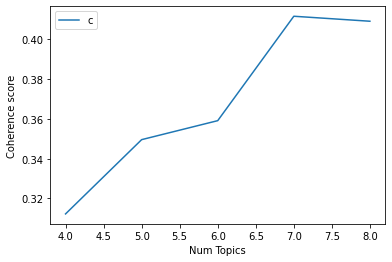

In [7]:
# Parameters
limit=9; start=4; step=1;

# Warning: This cell takes a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus, texts=docs, 
                                                        start=start, limit=limit, step=step)

# Show graph
x = range(start, limit, step)
plt.plot(x,coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [8]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=6,
                       passes = 100, random_state = 100)

lda_model.save('data/ldamodel/ldareddit.model') 

# Visualise topic-word distribution¶

In [9]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.097092 -0.029315       1        1  26.117574
5     -0.078051  0.133838       2        1  17.166944
3     -0.058782  0.120361       3        1  16.119600
1     -0.095247  0.093616       4        1  13.913596
0      0.423752 -0.012603       5        1  13.437884
4     -0.094580 -0.305898       6        1  13.244402, topic_info=            Term           Freq          Total Category  logprob  loglift
143         home   25480.000000   25480.000000  Default  30.0000  30.0000
79   firefighter   15884.000000   15884.000000  Default  29.0000  29.0000
89    evacuation   17195.000000   17195.000000  Default  28.0000  28.0000
14         force   16200.000000   16200.000000  Default  27.0000  27.0000
0     california  115031.000000  115031.000000  Default  26.0000  26.0000
..           ...            ...            ...      ...      ...      ...
212         mail     617.142596     617.991697   Topic6  -5.3192   2.0202
569          use     631.941502     632.824033   Topic6  -5.2955   2.0202
10      wildfire   17758.567739  127950.505060   Topic6  -1.9597   0.0468
0     california   14988.879356  115031.941226   Topic6  -2.1292  -0.0163
66       burning    1784.930456    3675.758723   Topic6  -4.2572   1.2992

[240 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1891      4  0.999475       'ash
260       1  0.997966          .
36        5  0.999769       acre
161       6  0.999367  aftermath
1116      6  0.999418      allow
...     ...       ...        ...
10        5  0.072731   wildfire
10        6  0.138796   wildfire
300       3  0.999002       wind
1321      4  0.999800      woman
830       3  0.999832     worsen

[214 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 4, 2, 1, 5])

# Using word cloud to infer our topics

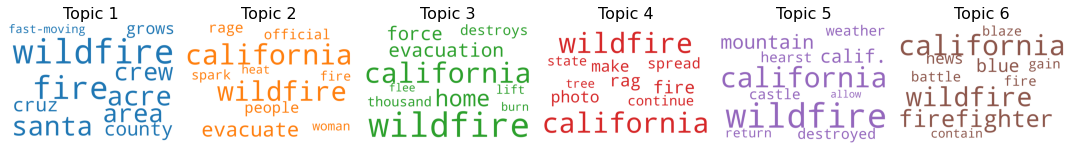

In [10]:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 6, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

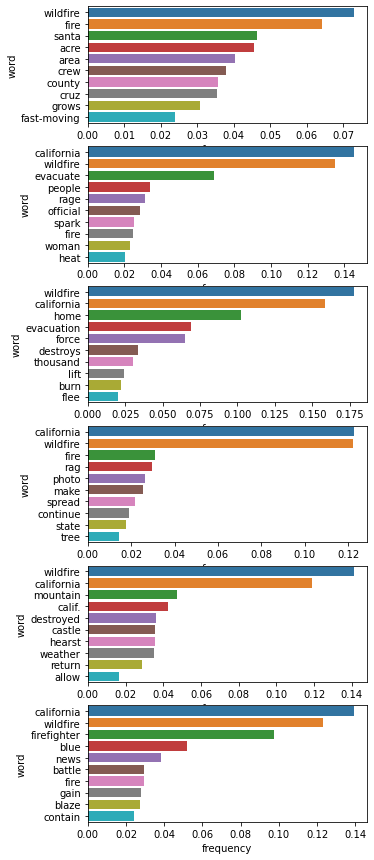

In [11]:
import seaborn as sns
f=plt.figure(figsize=(5,15))
    
for i in range(6):
    topic = pd.DataFrame(topics[i][1])
    topic.columns=['word','frequency']
    f.add_subplot(6,1,i+1)
    sns.barplot(data=topic,x="frequency",y="word")

# Generating dominant topic for each document

In [12]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=docs)
df_topic_keywords = pd.concat([df_topic_keywords, df.time], axis=1)
# df_topic_keywords.columns = ['Dominant_Topic', 'Topic_Perc_Contrib','keywords', 'title', 'date']
df_topic_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,title,time
0,1.0,0.5495,"california, wildfire, evacuate, people, rage, ...","[california, wildfire, update]",2016-08-30
1,1.0,0.8803,"california, wildfire, evacuate, people, rage, ...","[read, today, woman, drug, drive, spark, calif...",2016-08-30
2,0.0,0.6200,"wildfire, fire, santa, acre, area, crew, count...","[woman, drug, drive, spark, california, wildfire]",2016-08-30
3,1.0,0.8808,"california, wildfire, evacuate, people, rage, ...","[california, wildfire, update]",2016-08-30
4,0.0,0.4117,"wildfire, fire, santa, acre, area, crew, count...","[hop, pray, everyone, path, fast-moving, wildf...",2016-08-30
...,...,...,...,...,...
146695,1.0,0.5833,"california, wildfire, evacuate, people, rage, ...","[bernardino, mountain, wildfire, evacuation, l...",2016-08-13
146696,2.0,0.6800,"wildfire, california, home, evacuation, force,...","[bernardino, mountain, wildfire, evacuation, l...",2016-08-13
146697,2.0,0.4845,"wildfire, california, home, evacuation, force,...","[bernardino, mountain, evacuation, lift, ocreg...",2016-08-12
146698,2.0,0.6938,"wildfire, california, home, evacuation, force,...","[bernardino, mountain, wildfire, evacuation, l...",2016-08-12


# Plotting topic over time

In [13]:
topics = []
for i in range(6):
    wp = lda_model.show_topic(i)
    topic_keywords = ", ".join([word for word, prop in wp])
    topics.append(topic_keywords)
topics

['wildfire, fire, santa, acre, area, crew, county, cruz, grows, fast-moving',
 'california, wildfire, evacuate, people, rage, official, spark, fire, woman, heat',
 'wildfire, california, home, evacuation, force, destroys, thousand, lift, burn, flee',
 'california, wildfire, fire, rag, photo, make, spread, continue, state, tree',
 'wildfire, california, mountain, calif., destroyed, castle, hearst, weather, return, allow',
 'california, wildfire, firefighter, blue, news, battle, fire, gain, blaze, contain']

In [14]:
topic_time = pd.DataFrame()
for topic in topics:
    topici = df_topic_keywords[df_topic_keywords.Topic_Keywords==topic].groupby(df_topic_keywords.time).count().title
    topici.columns = [topic]
    topic_time = pd.concat([topic_time, topici], axis=1)
#topic_time.columns = topics
datelist = pd.date_range(start=pd.to_datetime('20160601'), end=pd.to_datetime('20160930'),freq='D')
topic_time = topic_time.reindex(datelist).fillna(0)
topic_time

,"wildfire, fire, santa, acre, area, crew, county, cruz, grows, fast-moving","california, wildfire, evacuate, people, rage, official, spark, fire, woman, heat","wildfire, california, home, evacuation, force, destroys, thousand, lift, burn, flee","california, wildfire, fire, rag, photo, make, spread, continue, state, tree","wildfire, california, mountain, calif., destroyed, castle, hearst, weather, return, allow","california, wildfire, firefighter, blue, news, battle, fire, gain, blaze, contain"
2016-06-01,1.0,0.0,2,0.0,5.0,2.0
2016-06-02,0.0,4.0,6,0.0,2.0,5.0
2016-06-03,2.0,4.0,4,2.0,2.0,15.0
2016-06-04,1.0,8.0,2,2.0,3.0,7.0
2016-06-05,45.0,153.0,355,107.0,123.0,118.0
...,...,...,...,...,...,...
2016-09-26,33.0,81.0,30,192.0,31.0,10.0
2016-09-27,55.0,180.0,144,421.0,205.0,32.0
2016-09-28,58.0,93.0,359,100.0,216.0,51.0
2016-09-29,20.0,35.0,151,37.0,213.0,46.0


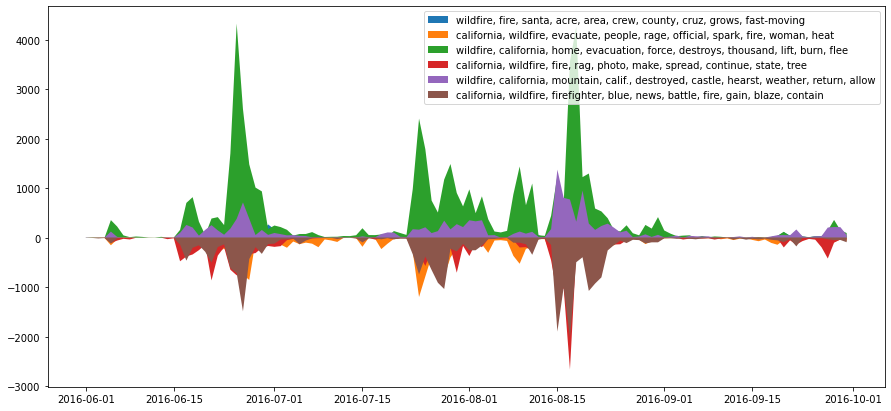

In [35]:
plt.figure(figsize=(15, 7))
for i in range(len(topics)):
    y = topic_time[topics[i]]
    x = topic_time.index
    if i%2==0:
        plt.stackplot(x,y) #,alpha=0.7) #,baseline='wiggle'
    else:
        plt.stackplot(x,-y) #,alpha=0.7) #,baseline='wiggle'
plt.legend(labels=topics)#,bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0) 
plt.show()

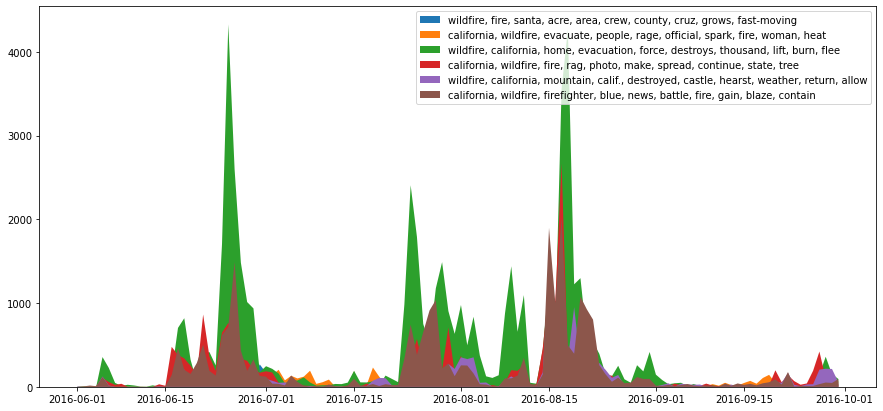

In [36]:
plt.figure(figsize=(15, 7))
for i in range(len(topics)):
    y = topic_time[topics[i]]
    x = topic_time.index
    plt.stackplot(x,y)# ,alpha = 0.7) #,baseline='wiggle'
plt.legend(labels=topics)#,bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0) 
plt.show()